In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
import random
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
from sklearn.model_selection import KFold

#then import my own modules
# from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight
from timeit import default_timer as timer
from AttentiveFP.featurizing import graph_dict
from AttentiveFP.AttentiveLayers_new2 import Fingerprint, graph_dataset, null_collate, Graph, Logger, time_to_str



In [2]:
cuda_aviable = torch.cuda.is_available()
device = torch.device(0)

SEED = 8
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic=True


In [3]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set()
from IPython.display import SVG, display
import sascorer

number of all smiles:  9999
number of successfully processed smiles:  9999


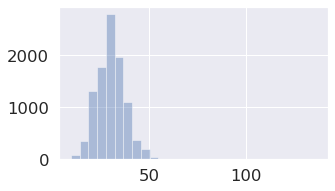

In [4]:
task_name = 'Malaria Bioactivity'
tasks = ['Loge EC50']

raw_filename = "../data/malaria-processed.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename, names = ["Loge EC50", "smiles"])
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))

smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)].reset_index()
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
plt.show()
plt.close()


In [5]:
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 200
epochs = 200

p_dropout= 0.2
fingerprint_dim = 32

weight_decay = 4 # also known as l2_regularization_lambda
learning_rate = 3
K = 3
T = 1
per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num

In [6]:
smiles_list = smiles_tasks_df['smiles'].values
label_list = smiles_tasks_df[tasks[0]].values
graph_dict = graph_dict(smiles_list, label_list, filename)


graph dicts loaded from ../data/malaria-processed.pkl


In [7]:
kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
train_fold = []
valid_fold = []
for k, (train_idx, valid_idx) in enumerate(kfold.split(smiles_list)):
    train_fold.append(train_idx)
    valid_fold.append(valid_idx)
    
while (len(train_fold[0]) % batch_size) / batch_size <0.8:
    batch_size +=1
print("batch size: ", batch_size)    

batch size:  200


In [8]:
loss_function = nn.MSELoss()
model = Fingerprint(output_units_num, fingerprint_dim, K=K, T=T, p_dropout=p_dropout)
model.to(device)

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in  model.parameters()])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

89797
preprocess.0.linear.weight torch.Size([32, 39])
preprocess.0.linear.bias torch.Size([32])
preprocess.0.bn.weight torch.Size([32])
preprocess.0.bn.bias torch.Size([32])
propagate.0.encoder.0.linear.weight torch.Size([1024, 10])
propagate.0.encoder.0.linear.bias torch.Size([1024])
propagate.0.encoder.0.bn.weight torch.Size([1024])
propagate.0.encoder.0.bn.bias torch.Size([1024])
propagate.0.align.weight torch.Size([1, 64])
propagate.0.align.bias torch.Size([1])
propagate.0.attend.linear.weight torch.Size([32, 32])
propagate.0.attend.linear.bias torch.Size([32])
propagate.0.attend.bn.weight torch.Size([32])
propagate.0.attend.bn.bias torch.Size([32])
propagate.0.gru.weight_ih torch.Size([96, 32])
propagate.0.gru.weight_hh torch.Size([96, 32])
propagate.0.gru.bias_ih torch.Size([96])
propagate.0.gru.bias_hh torch.Size([96])
propagate.1.encoder.0.linear.weight torch.Size([1024, 10])
propagate.1.encoder.0.linear.bias torch.Size([1024])
propagate.1.encoder.0.bn.weight torch.Size([1024])

In [9]:
def train(smiles_list):
    model.train()
    train_loader = DataLoader(graph_dataset(smiles_list, graph_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=True, worker_init_fn=np.random.seed(SEED))
    losses = []
    for b, (smiles, atom, bond, bond_index, mol_index, label) in enumerate(train_loader):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device)
        
        mol_prediction = model(atom, bond, bond_index, mol_index)
        
        loss = loss_function(mol_prediction, label.view(-1,1))     
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())

    return np.mean(losses)

        
def eval(smiles_list):
    model.eval()
    eval_MAE_list = []
    eval_MSE_list = []
    eval_loader = DataLoader(graph_dataset(smiles_list, graph_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=False, worker_init_fn=np.random.seed(SEED))
    for b, (smiles, atom, bond, bond_index, mol_index, label) in enumerate(eval_loader):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device)
        
        mol_prediction = model(atom, bond, bond_index, mol_index)
        MAE = F.l1_loss(mol_prediction, label.view(-1,1), reduction='none')        
        MSE = F.mse_loss(mol_prediction, label.view(-1,1), reduction='none')
        
        eval_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        eval_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
    return np.array(eval_MAE_list).mean(), np.array(eval_MSE_list).mean()


In [10]:
# log = Logger()
# log.open(f'{prefix_filename}_{start_time}.txt')

# f = '{:^5} | {:^7.4f} | {:^7.4f} | {:^7.4f} | {:^7} \n'
# log.write('epoch | loss | train MSE |  valid MSE |  time \n')
# start = timer()

# best_param ={}
# best_param["train_epoch"] = 0
# best_param["valid_epoch"] = 0
# best_param["train_MSE"] = 9e8
# best_param["valid_MSE"] = 9e8

# fold_index = 0
# for epoch in range(800):
#     losses = train(smiles_list[train_fold[fold_index]])
#     traine_MAE, train_MSE = eval(smiles_list[train_fold[fold_index]])
#     valid_MAE, valid_MSE = eval(smiles_list[valid_fold[fold_index]])

#     timing = time_to_str((timer() - start), 'min')  
#     log.write(f.format(epoch, losses, train_MSE, valid_MSE, timing))

#     if train_MSE < best_param["train_MSE"]:
#         best_param["train_epoch"] = epoch
#         best_param["train_MSE"] = train_MSE
#     if valid_MSE < best_param["valid_MSE"]:
#         best_param["valid_epoch"] = epoch
#         best_param["valid_MSE"] = valid_MSE
# #         if valid_MSE < 0.35:
# #              torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
#     if (epoch - best_param["train_epoch"] >10) and (epoch - best_param["valid_epoch"] >18):        
#         break
# print(best_param["valid_epoch"],best_param["train_MSE"],best_param["valid_MSE"])

In [11]:

log = Logger()
log.open(f'{prefix_filename}_{start_time}.txt')

f = '{:^5} | {:^7.4f} | {:^7.4f} | {:^7.4f} | {:^7} \n'
log.write('epoch | loss | train MSE |  valid MSE |  time \n')
start = timer()

log2 = Logger()
log2.open(f'{prefix_filename}_best_{start_time}.txt')
f2 = '{:^5} | {:^5} | {:^7.4f} | {:^7.4f} \n'

for fold_index in range(5):
    
    model = Fingerprint(output_units_num, fingerprint_dim, K=K, T=T, p_dropout=p_dropout)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
    
    best_param ={}
    best_param["train_epoch"] = 0
    best_param["valid_epoch"] = 0
    best_param["train_MSE"] = 9e8
    best_param["valid_MSE"] = 9e8
    for epoch in range(800):
        losses = train(smiles_list[train_fold[fold_index]])
        traine_MAE, train_MSE = eval(smiles_list[train_fold[fold_index]])
        valid_MAE, valid_MSE = eval(smiles_list[valid_fold[fold_index]])
        
        timing = time_to_str((timer() - start), 'min')  
        log.write(f.format(epoch, losses, train_MSE, valid_MSE, timing))
        
        if train_MSE < best_param["train_MSE"]:
            best_param["train_epoch"] = epoch
            best_param["train_MSE"] = train_MSE
        if valid_MSE < best_param["valid_MSE"]:
            best_param["valid_epoch"] = epoch
            best_param["valid_MSE"] = valid_MSE
#             if valid_MSE < 0.35:
#                  torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
        if (epoch - best_param["train_epoch"] >18) and (epoch - best_param["valid_epoch"] >28):        
            break

    log2.write('fold | epoch | train_MSE | valid MSE \n')
    log2.write(f2.format(fold_index, best_param["valid_epoch"],best_param["train_MSE"],best_param["valid_MSE"]))
    
    

epoch | loss | train MSE |  valid MSE |  time 
  0   | 1.3613  | 1.4432  | 1.5165  |  0 hr 00 min 
  1   | 1.2475  | 1.2383  | 1.3643  |  0 hr 00 min 
  2   | 1.2292  | 1.1760  | 1.3356  |  0 hr 00 min 
  3   | 1.1963  | 1.1540  | 1.2988  |  0 hr 00 min 
  4   | 1.1812  | 1.1326  | 1.2862  |  0 hr 00 min 
  5   | 1.1757  | 1.1040  | 1.2395  |  0 hr 00 min 
  6   | 1.1487  | 1.1019  | 1.2781  |  0 hr 01 min 
  7   | 1.1359  | 1.1037  | 1.2839  |  0 hr 01 min 
  8   | 1.1144  | 1.1097  | 1.2805  |  0 hr 01 min 
  9   | 1.1087  | 1.0962  | 1.2569  |  0 hr 01 min 
 10   | 1.0986  | 1.0302  | 1.2005  |  0 hr 01 min 
 11   | 1.0757  | 1.0615  | 1.2497  |  0 hr 01 min 
 12   | 1.0703  | 1.0247  | 1.2019  |  0 hr 01 min 
 13   | 1.0748  | 1.0355  | 1.2349  |  0 hr 02 min 
 14   | 1.0560  | 0.9883  | 1.1963  |  0 hr 02 min 
 15   | 1.0356  | 0.9880  | 1.1825  |  0 hr 02 min 
 16   | 1.0290  | 0.9888  | 1.2123  |  0 hr 02 min 
 17   | 1.0303  | 0.9684  | 1.2032  |  0 hr 02 min 
 18   | 1.0177  |

 157  | 0.3798  | 0.2523  | 1.3880  |  0 hr 13 min 
 158  | 0.3762  | 0.2428  | 1.4038  |  0 hr 13 min 
 159  | 0.3683  | 0.2493  | 1.4177  |  0 hr 13 min 
 160  | 0.3709  | 0.2505  | 1.4105  |  0 hr 13 min 
 161  | 0.3729  | 0.2512  | 1.4006  |  0 hr 13 min 
 162  | 0.3744  | 0.2419  | 1.3664  |  0 hr 13 min 
 163  | 0.3619  | 0.2504  | 1.4409  |  0 hr 13 min 
 164  | 0.3675  | 0.2533  | 1.3923  |  0 hr 13 min 
 165  | 0.3580  | 0.2445  | 1.4397  |  0 hr 13 min 
 166  | 0.3572  | 0.2410  | 1.3922  |  0 hr 14 min 
 167  | 0.3548  | 0.2409  | 1.4268  |  0 hr 14 min 
 168  | 0.3615  | 0.2510  | 1.4349  |  0 hr 14 min 
 169  | 0.3643  | 0.2375  | 1.4688  |  0 hr 14 min 
 170  | 0.3619  | 0.2359  | 1.4144  |  0 hr 14 min 
 171  | 0.3604  | 0.2445  | 1.4174  |  0 hr 14 min 
 172  | 0.3625  | 0.2390  | 1.4254  |  0 hr 14 min 
 173  | 0.3486  | 0.2391  | 1.4299  |  0 hr 14 min 
 174  | 0.3542  | 0.2436  | 1.3998  |  0 hr 14 min 
 175  | 0.3405  | 0.2336  | 1.4465  |  0 hr 14 min 
 176  | 0.34

 315  | 0.2544  | 0.1492  | 1.4083  |  0 hr 28 min 
 316  | 0.2385  | 0.1358  | 1.3950  |  0 hr 28 min 
 317  | 0.2468  | 0.1408  | 1.4407  |  0 hr 28 min 
 318  | 0.2385  | 0.1516  | 1.4681  |  0 hr 28 min 
 319  | 0.2364  | 0.1407  | 1.4331  |  0 hr 28 min 
 320  | 0.2340  | 0.1412  | 1.4482  |  0 hr 28 min 
 321  | 0.2461  | 0.1509  | 1.5009  |  0 hr 28 min 
 322  | 0.2595  | 0.1573  | 1.4317  |  0 hr 28 min 
 323  | 0.2527  | 0.1506  | 1.4266  |  0 hr 28 min 
 324  | 0.2559  | 0.1421  | 1.4104  |  0 hr 29 min 
 325  | 0.2493  | 0.1417  | 1.4052  |  0 hr 29 min 
 326  | 0.2407  | 0.1463  | 1.4267  |  0 hr 29 min 
 327  | 0.2467  | 0.1323  | 1.4313  |  0 hr 29 min 
 328  | 0.2414  | 0.1490  | 1.4398  |  0 hr 29 min 
 329  | 0.2457  | 0.1379  | 1.4044  |  0 hr 29 min 
 330  | 0.2355  | 0.1412  | 1.4223  |  0 hr 29 min 
 331  | 0.2475  | 0.1463  | 1.4516  |  0 hr 29 min 
 332  | 0.2485  | 0.1403  | 1.4286  |  0 hr 29 min 
 333  | 0.2387  | 0.1373  | 1.4128  |  0 hr 29 min 
 334  | 0.24

 14   | 1.0870  | 1.0377  | 1.1131  |  0 hr 41 min 
 15   | 1.0616  | 0.9867  | 1.0783  |  0 hr 41 min 
 16   | 1.0470  | 0.9908  | 1.0732  |  0 hr 42 min 
 17   | 1.0462  | 0.9973  | 1.0979  |  0 hr 42 min 
 18   | 1.0340  | 0.9654  | 1.0879  |  0 hr 42 min 
 19   | 1.0172  | 0.9542  | 1.0638  |  0 hr 42 min 
 20   | 1.0089  | 0.9259  | 1.0693  |  0 hr 42 min 
 21   | 1.0084  | 0.9490  | 1.0699  |  0 hr 42 min 
 22   | 0.9969  | 0.9309  | 1.0716  |  0 hr 42 min 
 23   | 0.9953  | 0.9001  | 1.0403  |  0 hr 42 min 
 24   | 0.9711  | 0.8985  | 1.0749  |  0 hr 42 min 
 25   | 0.9745  | 0.9135  | 1.0663  |  0 hr 42 min 
 26   | 0.9581  | 0.8837  | 1.0615  |  0 hr 42 min 
 27   | 0.9504  | 0.9189  | 1.0937  |  0 hr 42 min 
 28   | 0.9564  | 0.8852  | 1.0736  |  0 hr 43 min 
 29   | 0.9380  | 0.8740  | 1.0696  |  0 hr 43 min 
 30   | 0.9271  | 0.8398  | 1.0438  |  0 hr 43 min 
 31   | 0.9241  | 0.8321  | 1.0653  |  0 hr 43 min 
 32   | 0.9182  | 0.8266  | 1.0485  |  0 hr 43 min 
 33   | 0.90

 172  | 0.3819  | 0.2486  | 1.2146  |  0 hr 54 min 
 173  | 0.3911  | 0.2904  | 1.2760  |  0 hr 54 min 
 174  | 0.4169  | 0.2770  | 1.2544  |  0 hr 54 min 
 175  | 0.3964  | 0.2608  | 1.2467  |  0 hr 54 min 
 176  | 0.3871  | 0.2591  | 1.2587  |  0 hr 54 min 
 177  | 0.4004  | 0.2578  | 1.2452  |  0 hr 54 min 
 178  | 0.3857  | 0.2528  | 1.2431  |  0 hr 54 min 
 179  | 0.3861  | 0.2460  | 1.2542  |  0 hr 54 min 
 180  | 0.3744  | 0.2459  | 1.2720  |  0 hr 54 min 
 181  | 0.3764  | 0.2350  | 1.2624  |  0 hr 55 min 
 182  | 0.3769  | 0.2586  | 1.2556  |  0 hr 55 min 
 183  | 0.3853  | 0.2556  | 1.2772  |  0 hr 55 min 
 184  | 0.3790  | 0.2419  | 1.2366  |  0 hr 55 min 
 185  | 0.3766  | 0.2541  | 1.2103  |  0 hr 55 min 
 186  | 0.3757  | 0.2462  | 1.2208  |  0 hr 55 min 
 187  | 0.3717  | 0.2480  | 1.2331  |  0 hr 55 min 
 188  | 0.3684  | 0.2377  | 1.2545  |  0 hr 56 min 
 189  | 0.3677  | 0.2513  | 1.2674  |  0 hr 56 min 
 190  | 0.3648  | 0.2480  | 1.3429  |  0 hr 56 min 
 191  | 0.35

 330  | 0.2587  | 0.1358  | 1.2910  |  1 hr 08 min 
 331  | 0.2504  | 0.1425  | 1.2952  |  1 hr 08 min 
 332  | 0.2586  | 0.1431  | 1.2775  |  1 hr 08 min 
 333  | 0.2524  | 0.1483  | 1.3038  |  1 hr 08 min 
 334  | 0.2566  | 0.1497  | 1.2805  |  1 hr 08 min 
 335  | 0.2537  | 0.1447  | 1.2913  |  1 hr 08 min 
 336  | 0.2526  | 0.1414  | 1.2915  |  1 hr 08 min 
 337  | 0.2572  | 0.1401  | 1.3308  |  1 hr 08 min 
 338  | 0.2552  | 0.1528  | 1.3155  |  1 hr 09 min 
 339  | 0.2707  | 0.1642  | 1.3314  |  1 hr 09 min 
 340  | 0.2521  | 0.1443  | 1.2498  |  1 hr 09 min 
 341  | 0.2473  | 0.1339  | 1.3286  |  1 hr 09 min 
 342  | 0.2551  | 0.1405  | 1.2525  |  1 hr 09 min 
 343  | 0.2506  | 0.1364  | 1.2661  |  1 hr 10 min 
 344  | 0.2591  | 0.1440  | 1.3069  |  1 hr 10 min 
 345  | 0.2471  | 0.1366  | 1.2784  |  1 hr 10 min 
 346  | 0.2474  | 0.1334  | 1.3130  |  1 hr 10 min 
 347  | 0.2421  | 0.1469  | 1.2906  |  1 hr 10 min 
 348  | 0.2441  | 0.1297  | 1.3173  |  1 hr 10 min 
 349  | 0.24

 95   | 0.5514  | 0.4535  | 1.2268  |  1 hr 21 min 
 96   | 0.5545  | 0.4208  | 1.2085  |  1 hr 21 min 
 97   | 0.5430  | 0.4106  | 1.2195  |  1 hr 22 min 
 98   | 0.5545  | 0.4145  | 1.1946  |  1 hr 22 min 
 99   | 0.5469  | 0.4088  | 1.2434  |  1 hr 22 min 
 100  | 0.5476  | 0.4044  | 1.2363  |  1 hr 22 min 
 101  | 0.5313  | 0.4311  | 1.2478  |  1 hr 22 min 
 102  | 0.5260  | 0.4083  | 1.1925  |  1 hr 22 min 
 103  | 0.5289  | 0.4157  | 1.2573  |  1 hr 22 min 
 104  | 0.5252  | 0.3947  | 1.2587  |  1 hr 22 min 
 105  | 0.5160  | 0.3916  | 1.1925  |  1 hr 22 min 
 106  | 0.5289  | 0.3976  | 1.2166  |  1 hr 22 min 
 107  | 0.5178  | 0.4102  | 1.3046  |  1 hr 22 min 
 108  | 0.5108  | 0.3923  | 1.2374  |  1 hr 22 min 
 109  | 0.5263  | 0.4022  | 1.2100  |  1 hr 23 min 
 110  | 0.5057  | 0.3809  | 1.2217  |  1 hr 23 min 
 111  | 0.5113  | 0.3815  | 1.2903  |  1 hr 23 min 
 112  | 0.5103  | 0.3669  | 1.2052  |  1 hr 23 min 
 113  | 0.5079  | 0.3747  | 1.2736  |  1 hr 23 min 
 114  | 0.50

 253  | 0.3031  | 0.1796  | 1.3082  |  1 hr 35 min 
 254  | 0.3000  | 0.1788  | 1.2535  |  1 hr 35 min 
 255  | 0.2942  | 0.1724  | 1.2963  |  1 hr 35 min 
 256  | 0.2961  | 0.1725  | 1.2880  |  1 hr 35 min 
 257  | 0.3006  | 0.1790  | 1.3260  |  1 hr 35 min 
 258  | 0.2959  | 0.1851  | 1.3469  |  1 hr 35 min 
 259  | 0.2954  | 0.1735  | 1.3335  |  1 hr 35 min 
 260  | 0.2942  | 0.1779  | 1.2896  |  1 hr 35 min 
 261  | 0.2997  | 0.1782  | 1.3093  |  1 hr 36 min 
 262  | 0.2996  | 0.1858  | 1.3497  |  1 hr 36 min 
 263  | 0.3007  | 0.1820  | 1.2757  |  1 hr 36 min 
 264  | 0.2986  | 0.1737  | 1.2699  |  1 hr 36 min 
 265  | 0.3002  | 0.1844  | 1.2762  |  1 hr 36 min 
 266  | 0.3099  | 0.2149  | 1.3702  |  1 hr 36 min 
 267  | 0.2985  | 0.1718  | 1.3117  |  1 hr 36 min 
 268  | 0.2928  | 0.1831  | 1.2608  |  1 hr 36 min 
 269  | 0.2995  | 0.1788  | 1.3436  |  1 hr 36 min 
 270  | 0.2943  | 0.1728  | 1.2927  |  1 hr 36 min 
 271  | 0.2931  | 0.1705  | 1.2938  |  1 hr 36 min 
 272  | 0.27

 20   | 0.9981  | 0.9549  | 1.0970  |  1 hr 48 min 
 21   | 0.9845  | 0.9343  | 1.0884  |  1 hr 48 min 
 22   | 0.9909  | 0.8963  | 1.0763  |  1 hr 48 min 
 23   | 0.9819  | 0.8931  | 1.0513  |  1 hr 48 min 
 24   | 0.9592  | 0.9012  | 1.0756  |  1 hr 48 min 
 25   | 0.9609  | 0.8775  | 1.0816  |  1 hr 48 min 
 26   | 0.9397  | 0.8933  | 1.1132  |  1 hr 48 min 
 27   | 0.9565  | 0.8502  | 1.0685  |  1 hr 48 min 
 28   | 0.9275  | 0.8325  | 1.0648  |  1 hr 48 min 
 29   | 0.9286  | 0.8418  | 1.0621  |  1 hr 48 min 
 30   | 0.9312  | 0.8468  | 1.0652  |  1 hr 48 min 
 31   | 0.8971  | 0.8285  | 1.0560  |  1 hr 48 min 
 32   | 0.8901  | 0.8123  | 1.0575  |  1 hr 49 min 
 33   | 0.8903  | 0.7977  | 1.0574  |  1 hr 49 min 
 34   | 0.8769  | 0.7945  | 1.0575  |  1 hr 49 min 
 35   | 0.8800  | 0.8087  | 1.1209  |  1 hr 49 min 
 36   | 0.8750  | 0.7983  | 1.0902  |  1 hr 49 min 
 37   | 0.8654  | 0.7782  | 1.0422  |  1 hr 49 min 
 38   | 0.8627  | 0.7870  | 1.1000  |  1 hr 49 min 
 39   | 0.85

 178  | 0.3889  | 0.2560  | 1.2180  |  2 hr 02 min 
 179  | 0.3913  | 0.2582  | 1.2109  |  2 hr 02 min 
 180  | 0.3853  | 0.2475  | 1.1962  |  2 hr 03 min 
 181  | 0.3818  | 0.2466  | 1.1699  |  2 hr 03 min 
 182  | 0.3720  | 0.2596  | 1.1792  |  2 hr 03 min 
 183  | 0.3881  | 0.2435  | 1.1880  |  2 hr 03 min 
 184  | 0.3830  | 0.2550  | 1.1905  |  2 hr 03 min 
 185  | 0.3790  | 0.2482  | 1.2062  |  2 hr 03 min 
 186  | 0.3738  | 0.2587  | 1.1975  |  2 hr 03 min 
 187  | 0.3684  | 0.2501  | 1.2124  |  2 hr 03 min 
 188  | 0.3768  | 0.2406  | 1.2035  |  2 hr 03 min 
 189  | 0.3693  | 0.2488  | 1.2012  |  2 hr 04 min 
 190  | 0.3675  | 0.2459  | 1.1993  |  2 hr 04 min 
 191  | 0.3579  | 0.2407  | 1.1905  |  2 hr 04 min 
 192  | 0.3733  | 0.2392  | 1.2071  |  2 hr 04 min 
 193  | 0.3610  | 0.2310  | 1.2026  |  2 hr 04 min 
 194  | 0.3583  | 0.2498  | 1.2314  |  2 hr 04 min 
 195  | 0.3762  | 0.2417  | 1.1905  |  2 hr 04 min 
 196  | 0.3623  | 0.2332  | 1.2261  |  2 hr 04 min 
 197  | 0.36

 336  | 0.2594  | 0.1422  | 1.2451  |  2 hr 17 min 
 337  | 0.2556  | 0.1434  | 1.2564  |  2 hr 18 min 
 338  | 0.2549  | 0.1487  | 1.2469  |  2 hr 18 min 
 339  | 0.2577  | 0.1422  | 1.2042  |  2 hr 18 min 
 340  | 0.2563  | 0.1408  | 1.2540  |  2 hr 18 min 
 341  | 0.2595  | 0.1488  | 1.2387  |  2 hr 18 min 
 342  | 0.2662  | 0.1613  | 1.2623  |  2 hr 18 min 
 343  | 0.2651  | 0.1606  | 1.2452  |  2 hr 18 min 
 344  | 0.2700  | 0.1576  | 1.2279  |  2 hr 18 min 
 345  | 0.2620  | 0.1458  | 1.2463  |  2 hr 18 min 
 346  | 0.2536  | 0.1452  | 1.2349  |  2 hr 18 min 
 347  | 0.2553  | 0.1449  | 1.2333  |  2 hr 18 min 
 348  | 0.2465  | 0.1426  | 1.1882  |  2 hr 18 min 
 349  | 0.2531  | 0.1412  | 1.2381  |  2 hr 18 min 
 350  | 0.2483  | 0.1447  | 1.2454  |  2 hr 19 min 
 351  | 0.2438  | 0.1413  | 1.2538  |  2 hr 19 min 
 352  | 0.2543  | 0.1350  | 1.2604  |  2 hr 19 min 
 353  | 0.2619  | 0.1496  | 1.2042  |  2 hr 19 min 
 354  | 0.2621  | 0.1490  | 1.2981  |  2 hr 19 min 
 355  | 0.25

 56   | 0.7166  | 0.6408  | 1.2975  |  2 hr 31 min 
 57   | 0.7060  | 0.5894  | 1.2504  |  2 hr 31 min 
 58   | 0.6818  | 0.5870  | 1.2089  |  2 hr 31 min 
 59   | 0.6896  | 0.5989  | 1.2817  |  2 hr 31 min 
 60   | 0.6881  | 0.5804  | 1.2350  |  2 hr 31 min 
 61   | 0.6753  | 0.5789  | 1.3112  |  2 hr 31 min 
 62   | 0.6718  | 0.5572  | 1.3189  |  2 hr 31 min 
 63   | 0.6618  | 0.5456  | 1.2897  |  2 hr 31 min 
 64   | 0.6605  | 0.5608  | 1.3050  |  2 hr 31 min 
 65   | 0.6460  | 0.5467  | 1.3257  |  2 hr 31 min 
 66   | 0.6326  | 0.5448  | 1.3604  |  2 hr 32 min 
 67   | 0.6491  | 0.5384  | 1.2610  |  2 hr 32 min 
 68   | 0.6321  | 0.5323  | 1.2323  |  2 hr 32 min 
 69   | 0.6286  | 0.5118  | 1.3334  |  2 hr 32 min 
 70   | 0.6197  | 0.5102  | 1.2701  |  2 hr 32 min 
 71   | 0.6290  | 0.5071  | 1.2809  |  2 hr 32 min 
 72   | 0.6115  | 0.5458  | 1.3541  |  2 hr 32 min 
 73   | 0.6151  | 0.5017  | 1.3013  |  2 hr 32 min 
 74   | 0.6184  | 0.4952  | 1.2814  |  2 hr 32 min 
 75   | 0.59

 214  | 0.3259  | 0.2021  | 1.4181  |  2 hr 44 min 
 215  | 0.3264  | 0.2046  | 1.4151  |  2 hr 44 min 
 216  | 0.3148  | 0.2062  | 1.4245  |  2 hr 44 min 
 217  | 0.3209  | 0.2133  | 1.4556  |  2 hr 44 min 
 218  | 0.3218  | 0.2107  | 1.4698  |  2 hr 44 min 
 219  | 0.3229  | 0.2176  | 1.4397  |  2 hr 44 min 
 220  | 0.3237  | 0.2048  | 1.4575  |  2 hr 44 min 
 221  | 0.3210  | 0.2058  | 1.4360  |  2 hr 44 min 
 222  | 0.3231  | 0.2031  | 1.4553  |  2 hr 44 min 
 223  | 0.3173  | 0.2002  | 1.4281  |  2 hr 44 min 
 224  | 0.3196  | 0.2016  | 1.4425  |  2 hr 44 min 
 225  | 0.3201  | 0.2052  | 1.4372  |  2 hr 44 min 
 226  | 0.3195  | 0.2010  | 1.3897  |  2 hr 44 min 
 227  | 0.3188  | 0.2038  | 1.4963  |  2 hr 45 min 
 228  | 0.3139  | 0.2091  | 1.5117  |  2 hr 45 min 
 229  | 0.3189  | 0.2100  | 1.4512  |  2 hr 45 min 
 230  | 0.3135  | 0.1930  | 1.4527  |  2 hr 45 min 
 231  | 0.3021  | 0.1940  | 1.4284  |  2 hr 45 min 
 232  | 0.3169  | 0.1988  | 1.4615  |  2 hr 45 min 
 233  | 0.31

 372  | 0.2389  | 0.1290  | 1.4779  |  2 hr 56 min 
 373  | 0.2359  | 0.1327  | 1.4249  |  2 hr 56 min 
 374  | 0.2354  | 0.1282  | 1.5086  |  2 hr 56 min 
 375  | 0.2308  | 0.1256  | 1.4306  |  2 hr 57 min 
 376  | 0.2376  | 0.1318  | 1.4531  |  2 hr 57 min 
 377  | 0.2306  | 0.1223  | 1.4477  |  2 hr 57 min 
 378  | 0.2324  | 0.1340  | 1.4895  |  2 hr 57 min 
 379  | 0.2283  | 0.1267  | 1.4692  |  2 hr 57 min 
 380  | 0.2283  | 0.1300  | 1.4514  |  2 hr 57 min 
 381  | 0.2286  | 0.1341  | 1.4716  |  2 hr 57 min 
 382  | 0.2355  | 0.1432  | 1.5285  |  2 hr 57 min 
 383  | 0.2338  | 0.1341  | 1.4733  |  2 hr 57 min 
 384  | 0.2350  | 0.1313  | 1.4445  |  2 hr 57 min 
 385  | 0.2299  | 0.1373  | 1.4906  |  2 hr 57 min 
 386  | 0.2281  | 0.1182  | 1.4775  |  2 hr 57 min 
 387  | 0.2291  | 0.1252  | 1.4831  |  2 hr 57 min 
 388  | 0.2367  | 0.1250  | 1.4527  |  2 hr 58 min 
 389  | 0.2238  | 0.1295  | 1.4805  |  2 hr 58 min 
 390  | 0.2401  | 0.1287  | 1.4627  |  2 hr 58 min 
 391  | 0.22

In [12]:
# # evaluate model
# best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["valid_epoch"])+'.pt')     

# best_model_dict = best_model.state_dict()
# best_model_wts = copy.deepcopy(best_model_dict)

# model.load_state_dict(best_model_wts)
# (best_model.align[0].weight == model.align[0].weight).all()
# test_MAE, test_MSE = eval(model, test_df)
# print("best epoch:",best_param["test_epoch"],"\n","test MSE:",test_MSE)

In [13]:
# for e in range(20):
#     losses = train(smiles_list[valid_fold[fold_index]])
#     print(losses)